# MMED Week 2 Project: COVID-19

# The Impact of Timing od Non-Pharmaceutical Interventions (NPIs) on the Hospital's Bed Capacity for Covid-19 Outbreak in Italy.

Group 1<br>
Project: COVID-19 Decision Making<br><br>

**Students:**<br>
 - Annette Dariose Diffo Mboudjiho
 - Dishanand Jayeprokash
 - Oumarou MOUSSA BOLA
 - Shama German Wache
 - Tiwonge Chirwa
 - Yvan Marcel Carre

## Data Preparation

In [ ]:
# Install and load necessary packages
install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda"))


Installing packages into ‘/var/autofs/misc/home/jay/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

Warning message in install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda")):
“installation of package ‘deSolve’ had non-zero exit status”
Warning message in install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda")):
“installation of package ‘minpack.lm’ had non-zero exit status”


In [2]:
library(deSolve)
library(ggplot2)
library(minpack.lm)
library(coda)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Load the data
covid_bed<- read.csv("hospitalization.csv")
covid_bed <- covid_bed[1:150,]
head(covid_bed)

,Time,excluded_ICU_cases,ICU_cases,total_cases
,<chr>,<int>,<int>,<int>
1,2020-02-24,101,26,127
2,2020-02-25,114,35,149
3,2020-02-26,128,36,164
4,2020-02-27,248,56,304
5,2020-02-28,345,64,409
6,2020-02-29,401,105,506


In [4]:
dim(covid_bed)

[1] 150   4

In [5]:
# Preprocess the data - Convert Date column to Date type
covid_bed$Date <- as.Date(covid_bed$Time)
# Extract the count of hospitaloized cases
non_icu <- covid_bed$excluded_ICU_cases
icu <- covid_bed$ICU_cases
total_case <- covid_bed$total_cases
dates <- covid_bed$Date
times <- 1:length(total_case) # Time in days

## Visualization

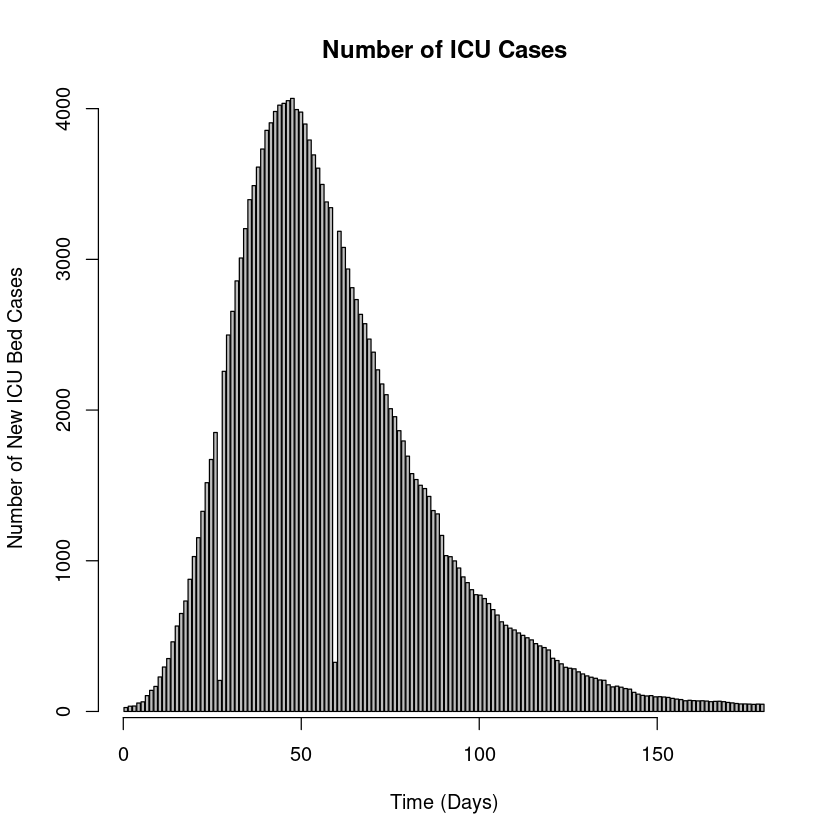

In [ ]:
# Plot the real data
barplot(covid_bed$ICU_cases, xlab = "Time (Days)", ylab = "Number of New ICU Bed Cases",
        main = "Number of ICU Cases")
axis(side = 1, at = seq(0,nrow(covid_bed), 50))

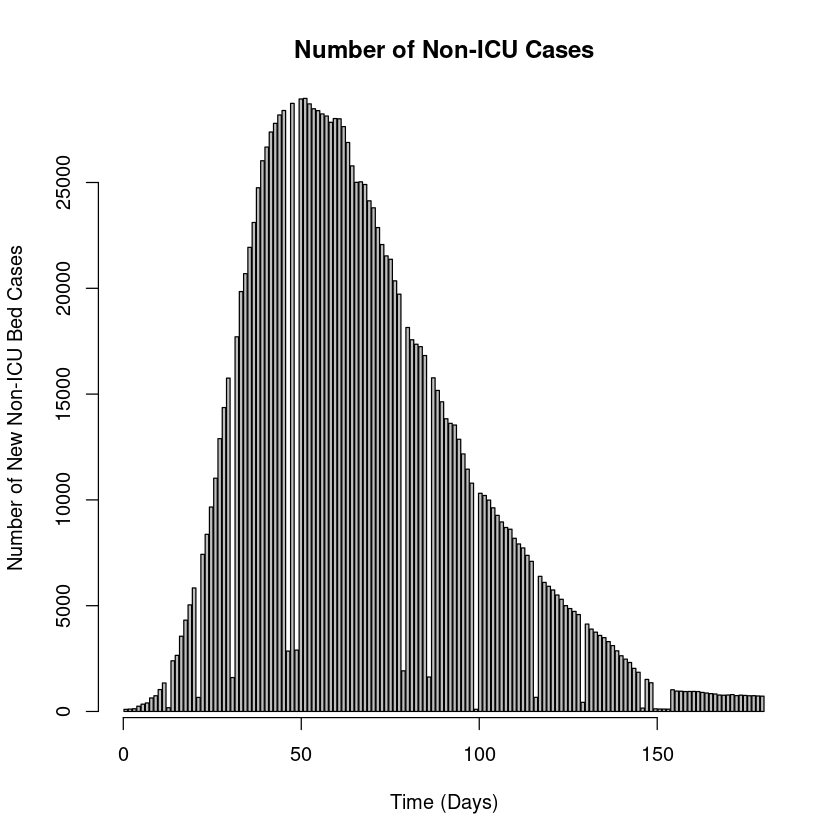

In [7]:
# Plot the real data
barplot(covid_bed$excluded_ICU_cases, xlab = "Time (Days)", ylab = "Number of New Non-ICU Bed Cases",
        main = "Number of Non-ICU Cases")
axis(side = 1, at = seq(0,nrow(covid_bed), 50))

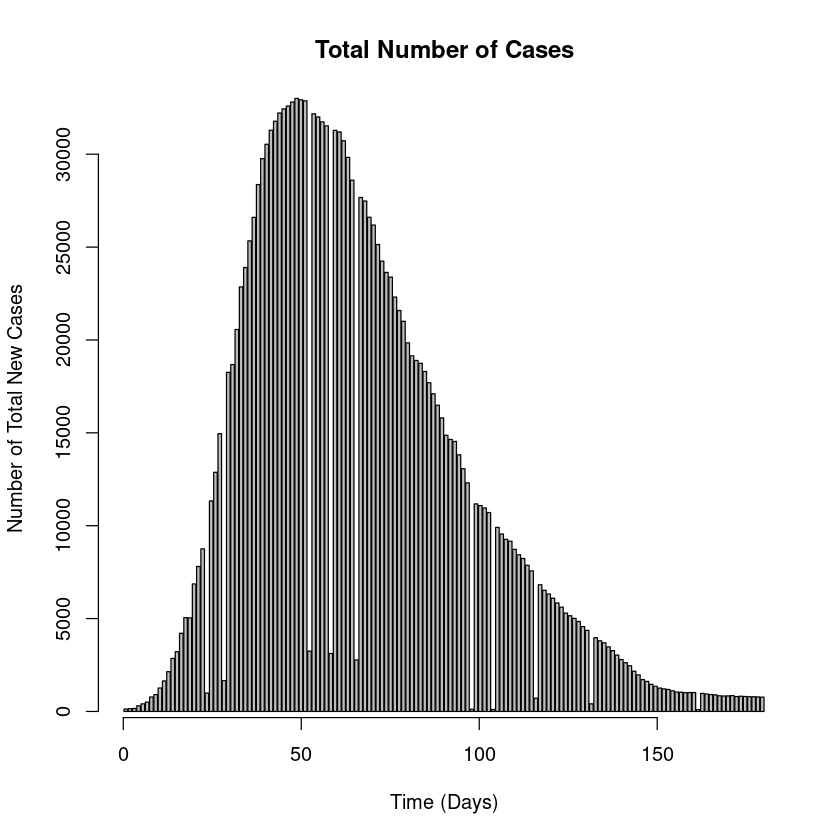

In [8]:
# Plot the real data
barplot(covid_bed$total_cases, xlab = "Time (Days)", ylab = "Number of Total New Cases",
        main = "Total Number of Cases")
axis(side = 1, at = seq(0,nrow(covid_bed), 50))

In [9]:
max(total_case)

[1] 33004

## Cummulative Cases of the Covid-19 Pandemic in Italy

In [10]:
# Convert 'Date' to the proper format and ensure it's sorted
covid_bed$Date <- as.Date(covid_bed$Date, format = "%Y-%m-%d")
covid_bed <- arrange(covid_bed, Date)

# Calculate the cumulative cases
covid_bed <- mutate(covid_bed, CumulativeCases = cumsum(total_cases))

# Calculate days since the start of the dataset
covid_bed <- mutate(covid_bed, DaysSinceStart = as.numeric(Date - min(Date)))

# Find the values for annotations
Feb_24_date <- as.numeric(as.Date("2020-02-24") - min(covid_bed$Date))
Feb_24_cases <- covid_bed$CumulativeCases[which(covid_bed$DaysSinceStart == Feb_24_date)]

Jul_23_date <- as.numeric(as.Date("2020-07-23") - min(covid_bed$Date))
Jul_23_cases <- covid_bed$CumulativeCases[which(covid_bed$DaysSinceStart == Jul_23_date)]


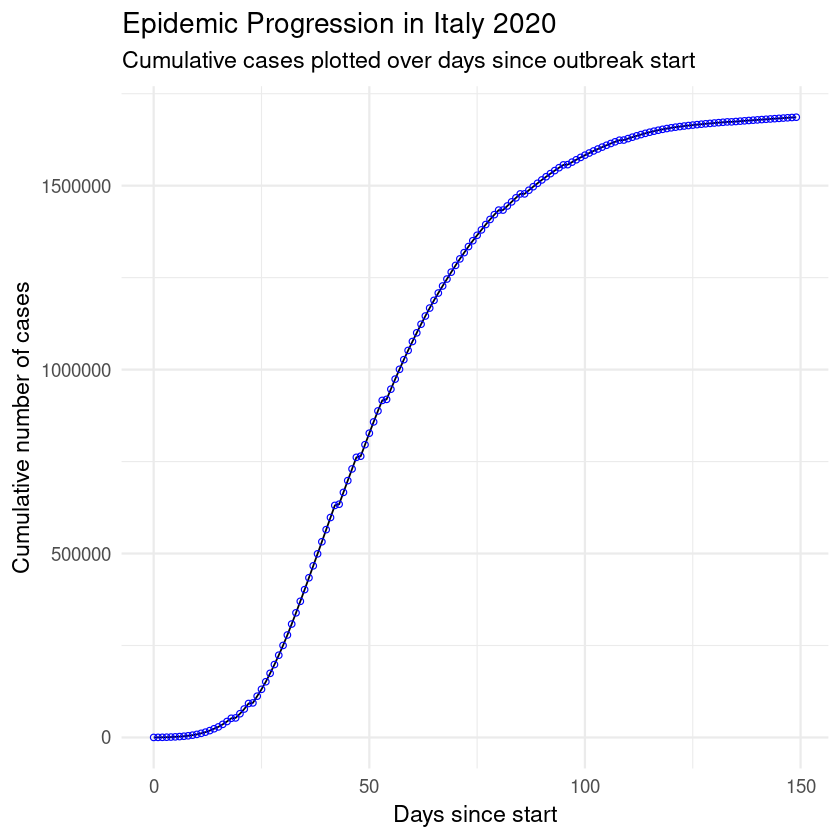

In [11]:
ggplot(covid_bed, aes(x = DaysSinceStart, y = CumulativeCases)) +
   geom_line() +  # Add the line for cumulative cases
  geom_point(color="blue",shape = 1) +  # Add points for each day
  scale_x_continuous(breaks = c(0, 50, 100, 150), labels = c("0", "50", "100", "150")) +
  annotate("text", x = Feb_24_date, y = Feb_24_cases, label = "Feb 24", color = "white", hjust = 1.5, vjust = -0.5, fontface = "bold", size = 5) +
  annotate("text", x = Jul_23_date, y = Jul_23_cases, label = "Jul 23", color = "white", hjust = -0.5, vjust = -0.5, fontface = "bold", size = 5) +
  labs(title = "Epidemic Progression in Italy 2020", subtitle = "Cumulative cases plotted over days since outbreak start", x = "Days since start", y = "Cumulative number of cases") +
  theme_minimal(base_size = 14) +
  theme(plot.background = element_rect(fill = "white", colour = "white"), 
        panel.background = element_rect(fill = "white", colour = "white"))  # Set background to white


In [12]:
getwd()

[1] "/var/autofs/misc/home/jay/Desktop/group_1_mmed/COVID-19-Making-Decision"

## $\beta$ as a Function of t

In [13]:
# Define the function to calculate beta(t)
#Transmission rate that model the delay of the intervention
beta_t <- function(t, tau, beta_0, beta_1, q) {
  if (t < tau) {
    return(beta_0)
  } else {
    return(beta_1 + (beta_0 - beta_1) * exp(-q * (t - tau)))
  }
}


## SEIR Model Implementation

In [14]:
# SEIR model differential equations : Taking new assumptions into account\

seir <- function(t, y, params) {
  S <- y[1]
  E <- y[2]
  I <- y[3]
  R <- y[4]
  B_n <-y[5]
  B_icu <-y[6]
    
  N = S + E + I + R + B_n + B_icu  # size of the population

  beta <- beta_t(t, params["tau"], params["beta_0"], params["beta_1"], params["q"])
  N <- params["N"]
  gamma <- params["gamma"]
  alpha <- params["alpha"]
  lambda1 <- params["lambda1"]
  lambda2 <- params["lambda2"]
  sigma<- params["sigma"]
  delta <- params["delta"]
  theta<- params["theta"]
    
      
    dSdt   <- -(beta*S*I)/N 

    dEdt   <- (beta*S*I)/N -sigma*E 

    dIdt   <- sigma*E-(gamma+alpha)*I

    dRdt   <- gamma*I+ theta*B_n

    dB_ndt <- alpha*I+lambda2*B_icu-(theta+lambda1)*B_n

    dB_icudt<- lambda1*B_n-(lambda2+ delta)*B_icu
    
  return(list(c(dSdt, dEdt, dIdt, dRdt,dB_ndt,dB_icudt)))
}


## Initial Conditions

In [55]:
# Parameters and initial conditions
latent_period=5.6 #[days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75  ,
  lambda1 =10,
  lambda2 =60.5  ,
  theta = 1/15,
  delta = 1/8,
  tau = 500,
  q = 100,
  N = 120000 ,
  sigma=1/latent_period  )  
    
initial_conditions <- c(S =120000-20, E = 10, I = 50, R = 0, B_n=10,B_icu=10)
times <- seq(1, 150, by = 1)

## Simulate SEIR Model

In [45]:
# Solve the SEIR model
seir_output <- ode(y = initial_conditions, times = times, func = seir, parms = params)


In [46]:
# Convert the output to a data frame
seir_df <- as.data.frame(seir_output)

In [47]:
head(seir_df)

,time,S,E,I,R,B_n,B_icu
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,119950.0,0.00000,50.00000,0.000000,0.00000,0.000000
2,2,119847.5,93.13071,28.86691,3.895649,22.69813,3.697831
3,3,119770.8,148.07621,27.73435,8.216199,38.06681,6.238265
4,4,119686.2,201.57845,33.60906,13.799325,54.13978,8.882569
5,5,119579.6,266.61778,43.35433,21.225886,73.97551,12.141484
6,6,119441.0,350.46132,56.69981,31.114932,99.54130,16.340428


In [48]:
dim(seir_df)

[1] 150   7

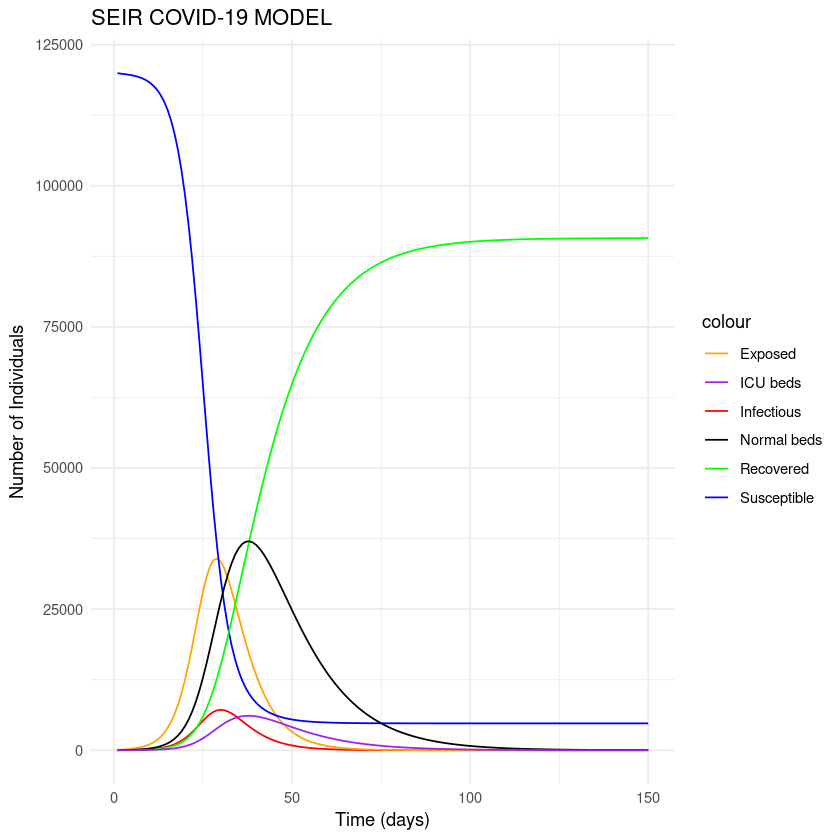

In [49]:
# Plot the simulation results
ggplot(seir_df, aes(x = time)) +
  geom_line(aes(y = I, color = "Infectious")) +
  geom_line(aes(y = E, color = "Exposed")) +
  geom_line(aes(y = S, color = "Susceptible")) +
  geom_line(aes(y = R, color = "Recovered")) +
  geom_line(aes(y = B_n, color = "Normal beds")) +
  geom_line(aes(y = B_icu, color = "ICU beds")) +
  labs(title = "SEIR COVID-19 MODEL",
       x = "Time (days)", y = "Number of Individuals") +
  scale_color_manual(values = c("Infectious" = "red", "Exposed" = "orange", "Susceptible" = "blue", "Recovered" ="green","Normal beds" = "black","ICU beds" = "purple")) +
  theme_minimal()

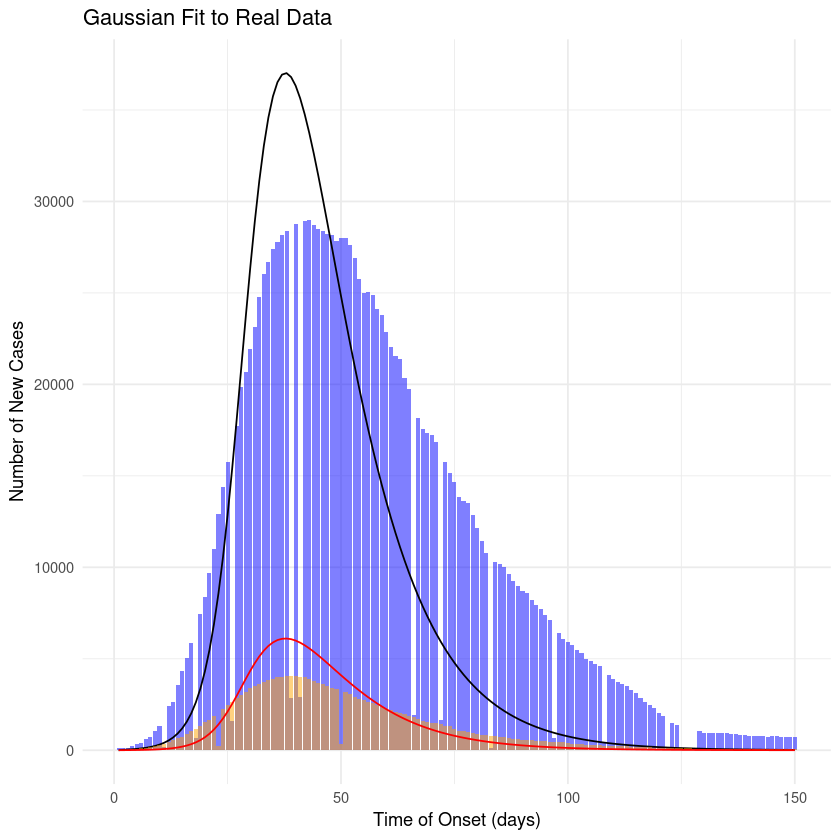

In [50]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = covid_bed, aes(x = times, y = non_icu), stat = "identity", fill = "blue", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_n), color = "black") +
geom_bar(data = covid_bed, aes(x = times, y = icu), stat = "identity", fill = "orange", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_icu), color = "red") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

In [ ]:
ggplot() +
  geom_bar(data = covid_bed, aes(x = times, y = non_icu, fill = "Non-ICU"), stat = "identity", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_n, color = "Gaussian Fit for Non-ICU")) +
  geom_bar(data = covid_bed, aes(x = times, y = icu, fill = "ICU"), stat = "identity", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_icu, color = "Gaussian Fit for ICU")) +
  scale_fill_manual(name = "Data Type", values = c("Non-ICU" = "blue", "ICU" = "orange")) +
  scale_color_manual(name = "Gaussian Fit", values = c("Gaussian Fit for Non-ICU" = "black", "Gaussian Fit for ICU" = "red")) +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal() +
  theme(legend.position = "bottom")


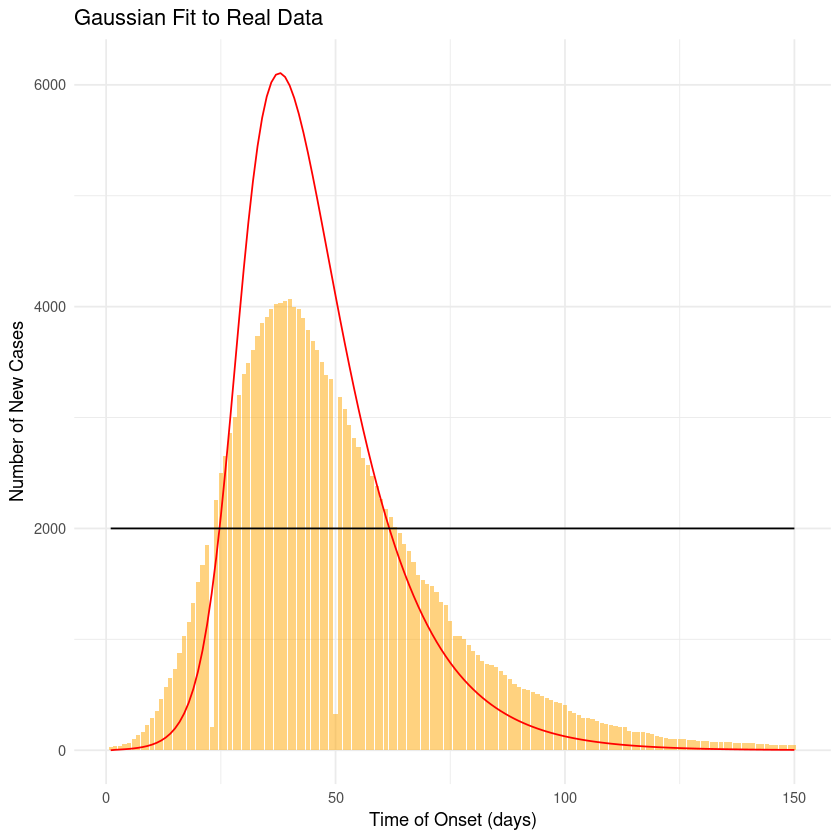

In [72]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = covid_bed, aes(x = times, y = icu), stat = "identity", fill = "orange", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_icu), color = "red") +
  geom_line(aes(x = times, y = 2000), color = "black") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

## Markov Chain Model To Plot S, E, I, R  Version 1

In [56]:
# # Markov Chain SEIR model with hospitalization compartments (B_N and B_ICU)
# simulate_markov_chain <- function(params, initial_conditions, times) {
#   S <- initial_conditions["S"]
#   E <- initial_conditions["E"]
#   I <- initial_conditions["I"]
#   R <- initial_conditions["R"]
#   B_n <- initial_conditions["B_n"]
#   B_icu <- initial_conditions["B_icu"]

#   N <- params["N"]
#   gamma <- params["gamma"]
#   alpha <- params["alpha"]
#   lambda1 <- params["lambda1"]
#   lambda2 <- params["lambda2"]
#   sigma <- params["sigma"]
#   delta <- params["delta"]
#   theta <- params["theta"]
#   q <- params["q"]
#   tau <- params["tau"]
#   beta_0 <- params["beta_0"]
#   beta_1 <- params["beta_1"]

#   results <- data.frame(time = times, 
#                         S = numeric(length(times)), 
#                         E = numeric(length(times)), 
#                         I = numeric(length(times)), 
#                         R = numeric(length(times)), 
#                         B_n = numeric(length(times)),
#                         B_icu = numeric(length(times)))

#   for (t in times) {
#     beta <- beta_tt(t, params)
    
#     # Calculate probabilities for the events
#     p_SE <- 1 - exp(-(beta * I) / N)
#     p_EI <- 1 - exp(-sigma)
#     p_IR <- 1 - exp(-gamma)
#     p_IBn <- 1 - exp(-alpha)
#     p_BnR <- 1 - exp(-theta)
#     p_BnBicu <- 1 - exp(-lambda1)
#     p_BicuBn <- 1 - exp(-lambda2)
    
#     # Simulate the transitions
#     new_exposed <- rbinom(1, S, p_SE)
#     new_infectious <- rbinom(1, E, p_EI)
#     new_recovered <- rbinom(1, I, p_IR)
#     new_Bn <- rbinom(1, I, p_IBn)
#     new_Bn_recovered <- rbinom(1, B_n, p_BnR)
#     new_Bicu <- rbinom(1, B_n, p_BnBicu)
#     new_Bn_from_Bicu <- rbinom(1, B_icu, p_BicuBn)
    
#     # Update the compartments
#     S <- S - new_exposed
#     E <- E + new_exposed - new_infectious
#     I <- I + new_infectious - new_recovered - new_Bn
#     R <- R + new_recovered + new_Bn_recovered
#     B_n <- B_n + new_Bn - new_Bn_recovered - new_Bicu + new_Bn_from_Bicu
#     B_icu <- B_icu + new_Bicu - new_Bn_from_Bicu

#     # Store the results
#     results[results$time == t, ] <- c(t, S, E, I, R, B_n, B_icu)
#   }

#   return(results)
# }

In [60]:
# Markov Chain SEIR model with hospitalization compartments (B_N and B_ICU)
simulate_markov_chain <- function(params, initial_conditions, times) {
  S <- initial_conditions["S"]
  E <- initial_conditions["E"]
  I <- initial_conditions["I"]
  R <- initial_conditions["R"]
  B_n <- initial_conditions["B_n"]
  B_icu <- initial_conditions["B_icu"]

  N <- params["N"]
  gamma <- params["gamma"]
  alpha <- params["alpha"]
  lambda1 <- params["lambda1"]
  lambda2 <- params["lambda2"]
  sigma <- params["sigma"]
  delta <- params["delta"]
  theta <- params["theta"]
  q <- params["q"]
  tau <- params["tau"]
  beta_0 <- params["beta_0"]
  beta_1 <- params["beta_1"]

  results <- data.frame(time = times, 
                        S = numeric(length(times)), 
                        E = numeric(length(times)), 
                        I = numeric(length(times)), 
                        R = numeric(length(times)), 
                        B_n = numeric(length(times)),
                        B_icu = numeric(length(times)))

  for (t in times) {
    beta <- beta_tt(t, params)
    
    # Calculate probabilities for the events
    p_SE <- 1 - exp(-(beta * I) / N)
    p_EI <- 1 - exp(-sigma)
    p_IR <- 1 - exp(-gamma)
    p_IBn <- 1 - exp(-alpha)
    p_BnR <- 1 - exp(-theta)
    p_BnBicu <- 1 - exp(-lambda1)
    p_BicuBn <- 1 - exp(-lambda2)

    # Ensure probabilities are within [0, 1]
    p_SE <- min(max(p_SE, 0), 1)
    p_EI <- min(max(p_EI, 0), 1)
    p_IR <- min(max(p_IR, 0), 1)
    p_IBn <- min(max(p_IBn, 0), 1)
    p_BnR <- min(max(p_BnR, 0), 1)
    p_BnBicu <- min(max(p_BnBicu, 0), 1)
    p_BicuBn <- min(max(p_BicuBn, 0), 1)

    # Debugging outputs
    if (any(is.na(c(p_SE, p_EI, p_IR, p_IBn, p_BnR, p_BnBicu, p_BicuBn)))) {
      cat("Warning: NA probabilities at time", t, "\n")
      print(data.frame(time = t, p_SE = p_SE, p_EI = p_EI, p_IR = p_IR, p_IBn = p_IBn, p_BnR = p_BnR, p_BnBicu = p_BnBicu, p_BicuBn = p_BicuBn))
    }

    # Simulate the transitions
    new_exposed <- rbinom(1, S, p_SE)
    new_infectious <- rbinom(1, E, p_EI)
    new_recovered <- rbinom(1, I, p_IR)
    new_Bn <- rbinom(1, I, p_IBn)
    new_Bn_recovered <- rbinom(1, B_n, p_BnR)
    new_Bicu <- rbinom(1, B_n, p_BnBicu)
    new_Bn_from_Bicu <- rbinom(1, B_icu, p_BicuBn)

    # Update the compartments
    S <- S - new_exposed
    E <- E + new_exposed - new_infectious
    I <- I + new_infectious - new_recovered - new_Bn
    R <- R + new_recovered + new_Bn_recovered
    B_n <- B_n + new_Bn - new_Bn_recovered - new_Bicu + new_Bn_from_Bicu
    B_icu <- B_icu + new_Bicu - new_Bn_from_Bicu

    # Ensure compartments are non-negative
    S <- max(S, 0)
    E <- max(E, 0)
    I <- max(I, 0)
    R <- max(R, 0)
    B_n <- max(B_n, 0)
    B_icu <- max(B_icu, 0)

    # Store the results
    results[results$time == t, ] <- c(t, S, E, I, R, B_n, B_icu)
  }

  return(results)
}

In [61]:
# Simulate the Markov Chain model
markov_results <- simulate_markov_chain(params, initial_conditions, times)


In [62]:
head(markov_results)

,time,S,E,I,R,B_n,B_icu
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,119856,133,20,6,35,10
2,2,119795,173,28,7,22,35
3,3,119713,222,45,11,47,22
4,4,119593,296,61,20,43,47
5,5,119417,422,74,30,74,43
6,6,119238,531,105,42,70,74


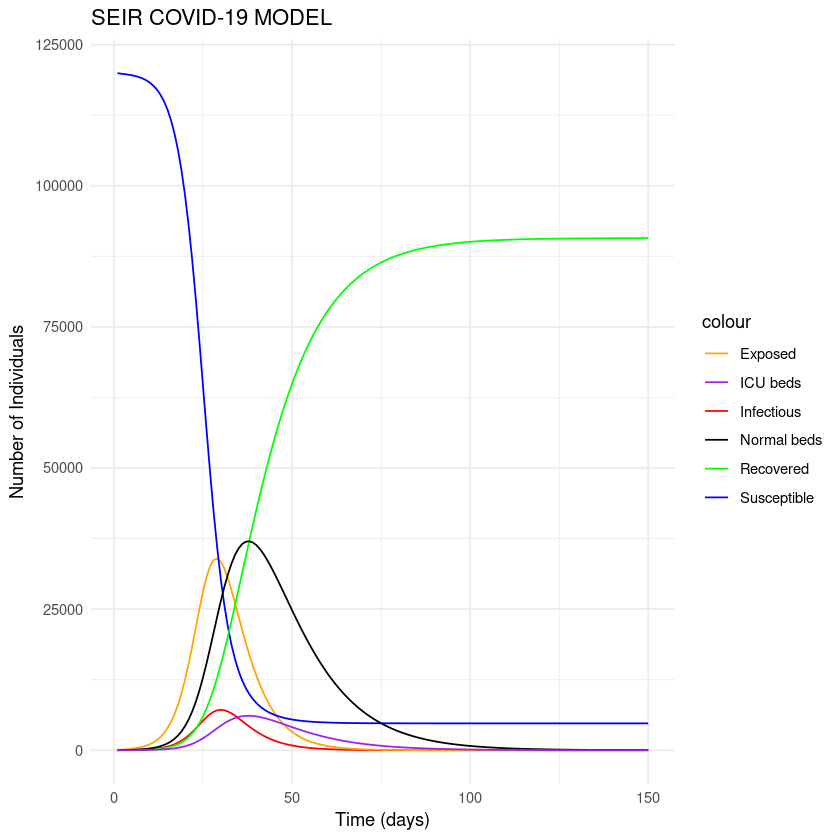

In [64]:
# Plot the simulation results
ggplot(seir_df, aes(x = time)) +
  geom_line(aes(y = I, color = "Infectious")) +
  geom_line(aes(y = E, color = "Exposed")) +
  geom_line(aes(y = S, color = "Susceptible")) +
  geom_line(aes(y = R, color = "Recovered")) +
  geom_line(aes(y = B_n, color = "Normal beds")) +
  geom_line(aes(y = B_icu, color = "ICU beds")) +
  labs(title = "SEIR COVID-19 MODEL",
       x = "Time (days)", y = "Number of Individuals") +
  scale_color_manual(values = c("Infectious" = "red", "Exposed" = "orange", "Susceptible" = "blue", "Recovered" ="green","Normal beds" = "black","ICU beds" = "purple")) +
  theme_minimal()

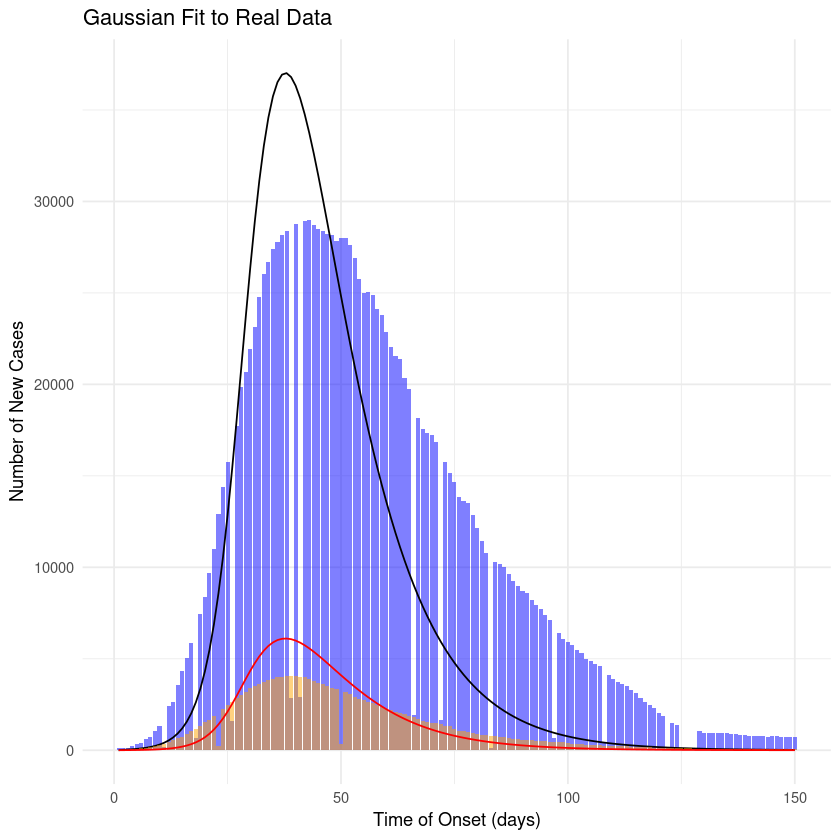

In [65]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = covid_bed, aes(x = times, y = non_icu), stat = "identity", fill = "blue", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_n), color = "black") +
  geom_bar(data = covid_bed, aes(x = times, y = icu), stat = "identity", fill = "orange", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_icu), color = "red") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

## Calculating $R_{0}$

In [ ]:
# # Define the function to calculate R0 over time
# R0_over_time <- function(t, R0_max, beta, period) {
#   R0_max * (1 + beta * exp(-1 * pi * t / period) + cos(1.5 * pi * t / period))
# }

In [ ]:
# # Define parameters
# R0_max <- 0.9
# beta <- 0.1
# period <- 365

In [ ]:
# # Calculate R0 values
# R0_values <- R0_over_time(times, R0_max, beta, period)

In [ ]:
# # Plot R0 over time
# ggplot(data.frame(time = times, R0 = R0_values), aes(x = time, y = R0)) +
#   geom_line(color = "blue") +
#   labs(title = "Reproductive Number (R0) Over Time",
#        x = "Time (days)", y = "Reproductive Number (R0)") +
#   theme_minimal()

## Markov Chain Model Version 2

## Initial Conditions

In [66]:
# Parameters and initial conditions
latent_period <- 5.6  # [days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75,
  lambda1 = 10,
  lambda2 = 60.5,
  theta = 1/15,
  delta = 1/8,
  tau = 500,
  q = 100,
  N = 120000,
  sigma = 1/latent_period
)

initial_conditions <- c(S = 120000 - 20, E = 10, I = 50, R = 0, B_n = 10, B_icu = 10)
times <- seq(1, 150, by = 1)


In [67]:
# Calculate beta(t) dynamically based on time
beta_tt <- function(t, params) {
  if (t < params["tau"]) {
    return(params["beta_0"])
  } else {
    return(params["beta_1"] + (params["beta_0"] - params["beta_1"]) * exp(-params["q"] * (t - params["tau"])))
  }
}


In [68]:
# Stochastic SEIR model using Gillespie Algorithm
seir_gillespie <- function(params, initial_conditions, times) {
  t <- 0
  results <- data.frame(time = t, 
                        S = initial_conditions["S"], 
                        E = initial_conditions["E"], 
                        I = initial_conditions["I"], 
                        R = initial_conditions["R"], 
                        B_n = initial_conditions["B_n"],
                        B_icu = initial_conditions["B_icu"]
                       )
  
  while(t < max(times)) {
    S <- results$S[nrow(results)]
    E <- results$E[nrow(results)]
    I <- results$I[nrow(results)]
    R <- results$R[nrow(results)]
    B_n <- results$B_n[nrow(results)]
    B_icu <- results$B_icu[nrow(results)]
      
    N <- params["N"]
    gamma <- params["gamma"]
    alpha <- params["alpha"]
    lambda1 <- params["lambda1"]
    lambda2 <- params["lambda2"]
    sigma <- params["sigma"]
    delta <- params["delta"]
    theta <- params["theta"]
    beta <- beta_tt(t, params)
    
    # Rates of transitions
    rate_infection <- ifelse(S > 0, beta * S * I / N, 0)
    rate_exposed_to_infectious <- ifelse(E > 0, sigma * E, 0)
    rate_infectious_to_recovered <- ifelse(I > 0, gamma * I, 0)
    rate_infectious_to_Bn <- ifelse(I > 0, alpha * I, 0)
    rate_Bn_to_recovered <- ifelse(B_n > 0, theta * B_n, 0)
    rate_Bn_to_B_icu <- ifelse(B_n > 0, lambda1 * B_n, 0)
    rate_Bicu_to_Bn <- ifelse(B_icu > 0, lambda2 * B_icu, 0)
    
    rates <- c(rate_infection, 
               rate_exposed_to_infectious, 
               rate_infectious_to_recovered,
               rate_infectious_to_Bn,
               rate_Bn_to_recovered,
               rate_Bn_to_B_icu,
               rate_Bicu_to_Bn
              )
    total_rate <- sum(rates)
    
    if(total_rate == 0) break
    
    # Time to next event
    dt <- rexp(1, total_rate)
    t <- t + dt
    
    # Determine which event occurs
    event <- sample(1:7, 1, prob = rates)
    
    if(event == 1 && S > 0) {
      S <- S - 1
      E <- E + 1
    } else if(event == 2 && E > 0) {
      E <- E - 1
      I <- I + 1
    } else if(event == 3 && I > 0) {
      I <- I - 1
      R <- R + 1
    } else if(event == 4 && I > 0) { 
      I <- I - 1
      B_n <- B_n + 1
    } else if(event == 5 && B_n > 0) { 
      B_n <- B_n - 1
      R <- R + 1
    } else if(event == 6 && B_n > 0) { 
      B_n <- B_n - 1
      B_icu <- B_icu + 1
    } else if(event == 7 && B_icu > 0) { 
      B_icu <- B_icu - 1
      B_n <- B_n + 1
    }
    
    results <- rbind(results, data.frame(time = t, S = S, E = E, I = I, R = R, B_n = B_n, B_icu = B_icu))
  }
  
  return(results)
}


In [69]:
# Number of simulations
num_simulations <- 5
all_simulations <- list()

for(i in 1:num_simulations) {
  sim_result <- seir_gillespie(params, initial_conditions, times)
  all_simulations[[i]] <- sim_result
}


In [70]:
# Function to extract the final epidemic size from each simulation
final_epidemic_size <- function(simulation) {
  return(max(simulation$C))
}

# Calculate final epidemic sizes for all simulations
final_sizes <- sapply(all_simulations, final_epidemic_size)

# Plot the distribution of final epidemic sizes
hist(final_sizes, breaks = 30, main = "Distribution of Final Epidemic Sizes", xlab = "Final Epidemic Size", ylab = "Frequency")

# Calculate summary statistics
summary(final_sizes)


ERROR: Error in hist.default(final_sizes, breaks = 30, main = "Distribution of Final Epidemic Sizes", : 'x' must be numeric


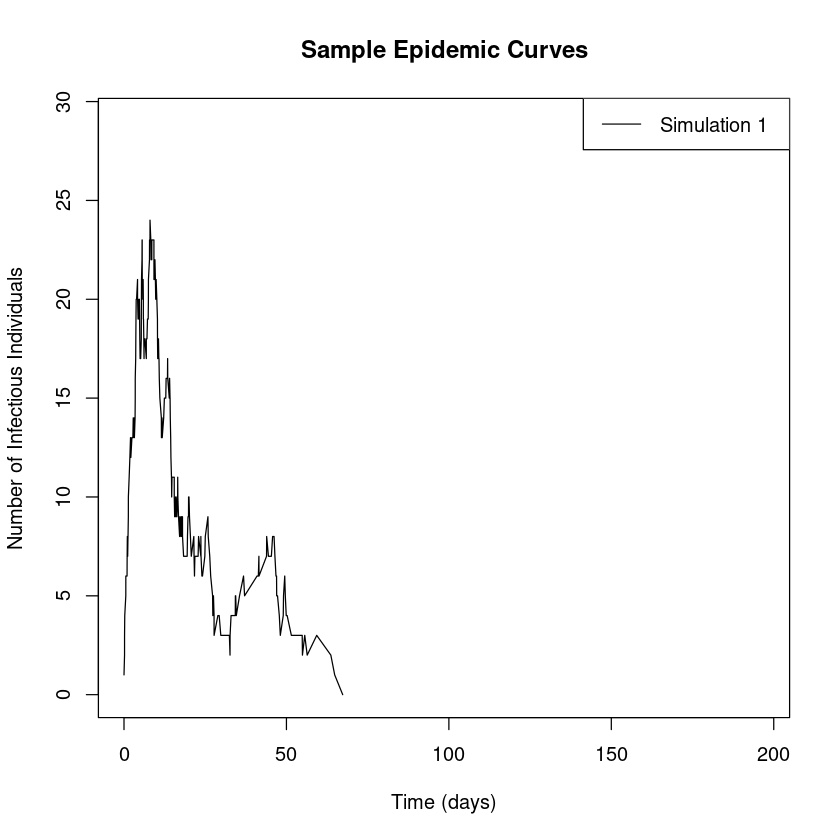

In [34]:
# Plot a few sample simulations
# sample_indices <- sample(1:num_simulations, 5)
sample_indices <- sample(1)


plot(NULL, xlim = c(0, max(times)), ylim = c(0, max(sapply(all_simulations, function(sim) max(sim$I)))), 
     xlab = "Time (days)", ylab = "Number of Infectious Individuals", main = "Sample Epidemic Curves")

for(i in sample_indices) {
  lines(all_simulations[[i]]$time, all_simulations[[i]]$I, col = i, type = "l")
}

legend("topright", legend = paste("Simulation", sample_indices), col = sample_indices, lty = 1)


## Markove Chain Model Version 3 for the Time of Intervention Delay

## Initial Conditions

In [76]:
# Parameters and initial conditions
latent_period=5.6 #[days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75  ,
  lambda1 =10,
  lambda2 =60.5  ,
  theta = 1/15,
  delta = 1/8,
  tau = 500,
  q = 100,
  N = 120000 ,
  sigma=1/latent_period  )  
    
initial_conditions <- c(S =120000-50, E = 10, I = 50, R = 10, B_n=10,B_icu=10)
times <- seq(1, 150, by = 1)

In [79]:
# Simplified Example Usage
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75,
  lambda1 = 10,
  lambda2 = 60.5,
  theta = 1/15,
  delta = 1/8,
  tau = 500,
  q = 100,
  N = 1200,  # Reduced population size for testing
  sigma = 1/5.6
)

initial_conditions <- c(S = 1200 - 20, E = 10, I = 50, R = 0, B_n = 10, B_icu = 10)
times <- seq(1, 50, by = 1)  # Reduced time range for testing


In [80]:
# Stochastic SEIR model using Gillespie Algorithm
seir_gillespie <- function(params, initial_conditions, times) {
  t <- 0
  results <- data.frame(time = t, 
                        S = initial_conditions["S"], 
                        E = initial_conditions["E"], 
                        I = initial_conditions["I"], 
                        R = initial_conditions["R"], 
                        B_n = initial_conditions["B_n"],
                        B_icu = initial_conditions["B_icu"]
                       )
  
  while(t < max(times)) {
    S <- results$S[nrow(results)]
    E <- results$E[nrow(results)]
    I <- results$I[nrow(results)]
    R <- results$R[nrow(results)]
    B_n <- results$B_n[nrow(results)]
    B_icu <- results$B_icu[nrow(results)]
      
    N <- params["N"]
    gamma <- params["gamma"]
    alpha <- params["alpha"]
    lambda1 <- params["lambda1"]
    lambda2 <- params["lambda2"]
    sigma <- params["sigma"]
    delta <- params["delta"]
    theta <- params["theta"]
    beta <- beta_tt(t, params)
    
    # Rates of transitions
    rate_infection <- ifelse(S > 0, beta * S * I / N, 0)
    rate_exposed_to_infectious <- ifelse(E > 0, sigma * E, 0)
    rate_infectious_to_recovered <- ifelse(I > 0, gamma * I, 0)
    rate_infectious_to_Bn <- ifelse(I > 0, alpha * I, 0)
    rate_Bn_to_recovered <- ifelse(B_n > 0, theta * B_n, 0)
    rate_Bn_to_B_icu <- ifelse(B_n > 0, lambda1 * B_n, 0)
    rate_Bicu_to_Bn <- ifelse(B_icu > 0, lambda2 * B_icu, 0)
    
    rates <- c(rate_infection, 
               rate_exposed_to_infectious, 
               rate_infectious_to_recovered,
               rate_infectious_to_Bn,
               rate_Bn_to_recovered,
               rate_Bn_to_B_icu,
               rate_Bicu_to_Bn
              )
    total_rate <- sum(rates)
    
    if(total_rate == 0) break
    
    # Time to next event
    dt <- rexp(1, total_rate)
    t <- t + dt
    
    # Determine which event occurs
    event <- sample(1:7, 1, prob = rates)
    
    if(event == 1 && S > 0) {
      S <- S - 1
      E <- E + 1
    } else if(event == 2 && E > 0) {
      E <- E - 1
      I <- I + 1
    } else if(event == 3 && I > 0) {
      I <- I - 1
      R <- R + 1
    } else if(event == 4 && I > 0) { 
      I <- I - 1
      B_n <- B_n + 1
    } else if(event == 5 && B_n > 0) {
      B_n <- B_n - 1
      R <- R + 1
    } else if(event == 6 && B_n > 0) {
      B_n <- B_n - 1
      B_icu <- B_icu + 1
    } else if(event == 7 && B_icu > 0) {
      B_icu <- B_icu - 1
      B_n <- B_n + 1
    }
    
    results <- rbind(results, data.frame(time = t, S = S, E = E, I = I, R = R, B_n = B_n, B_icu = B_icu))
  }
  
  return(results)
}


In [83]:

# # Number of simulations for each tau
# num_simulations <- 2

# # Define range of intervention times (tau)
# tau_values <- seq(0, 100, by = 50)

# # Collect results
# final_sizes <- data.frame(tau = tau_values, mean_final_size = NA, sd_final_size = NA)

# for (tau in tau_values) {
#   params["tau"] <- tau
#   epidemic_sizes <- numeric(num_simulations)
  
#   for (i in 1:num_simulations) {
#     sim_result <- seir_gillespie(params, initial_conditions, times)
#     epidemic_sizes[i] <- max(sim_result$B_icu)
#   }
  
#   final_sizes[final_sizes$tau == tau, "mean_final_size"] <- mean(epidemic_sizes)
#   final_sizes[final_sizes$tau == tau, "sd_final_size"] <- sd(epidemic_sizes)
# }

num_simulations <- 2
tau_values <- seq(0, 100, by = 50)
final_sizes <- data.frame(tau = tau_values, mean_final_size = NA, sd_final_size = NA)

for (tau in tau_values) {
  params["tau"] <- tau
  epidemic_sizes <- numeric(num_simulations)
  
  for (i in 1:num_simulations) {
    cat("Running simulation", i, "for tau =", tau, "\n")
    sim_result <- seir_gillespie(params, initial_conditions, times)
    epidemic_sizes[i] <- max(sim_result$I)
  }
  
  final_sizes[final_sizes$tau == tau, "mean_final_size"] <- mean(epidemic_sizes)
  final_sizes[final_sizes$tau == tau, "sd_final_size"] <- sd(epidemic_sizes)
}

print(final_sizes)

Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


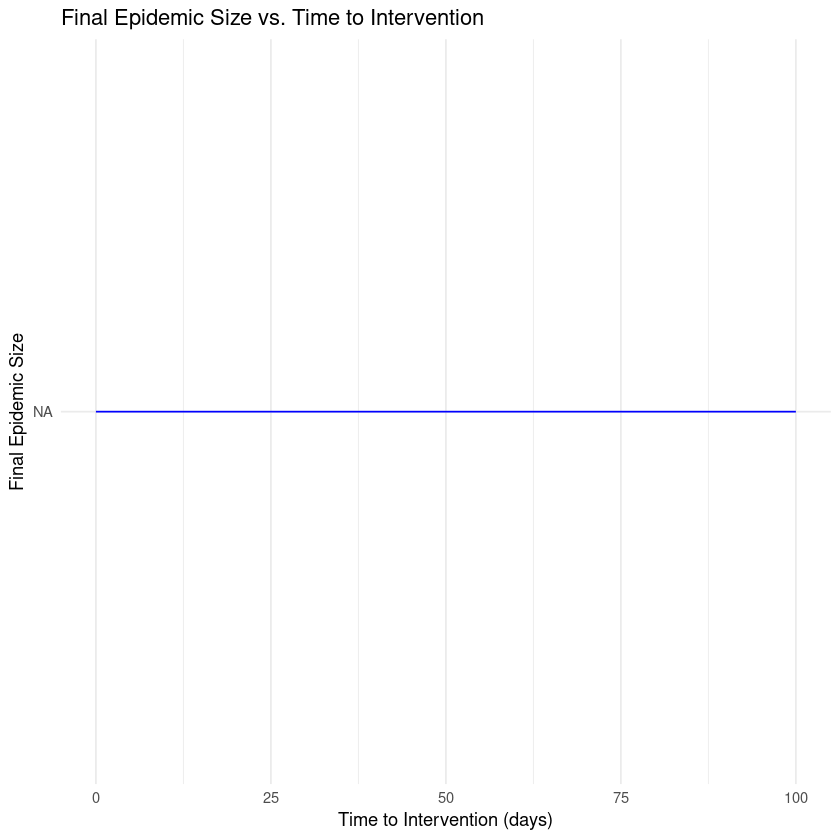

In [82]:
# Plot final epidemic size vs. time to intervention
ggplot(final_sizes, aes(x = tau, y = mean_final_size)) +
  geom_line(color = "blue") +
  geom_ribbon(aes(ymin = mean_final_size - sd_final_size, ymax = mean_final_size + sd_final_size), alpha = 0.2) +
  labs(title = "Final Epidemic Size vs. Time to Intervention",
       x = "Time to Intervention (days)",
       y = "Final Epidemic Size") +
  theme_minimal()


In [18]:
# # SEIR model differential equations
# seir <- function(t, y, params) {
#   S <- y[1]
#   E <- y[2]
#   I <- y[3]
#   R <- y[4]
#   B_n<-y[5]
#   B_icu <-y[6]
#   N=S+E+I+R+B_n+B_icu  # size of the population
#   beta <- beta_t(t, params["tau"], params["beta_0"], params["beta_1"], params["q"])
#   N <- params["N"]
#   gamma <- params["gamma"]
#   mu <- params["mu"]
#   b <- params["b"]
#   nu <- params["nu"]
#   alpha1 <- params["alpha1"]
#   alpha2 <- params["alpha2"]
#   eps1 <- params["eps1"]
#   eps2 <- params["eps2"]
#   lambda1 <- params["lambda1"]
#   lambda2 <- params["lambda2"]
    
# dSdt   <- b*N -(beta*S*I)/N -mu*S+nu*R
    
# dEdt   <- (beta*S*I)/N -sigma*E -mu*E
    
# dIdt   <- sigma*E-(gamma+mu+alpha1+alpha2)*I
    
# dRdt   <- gamma*I+eps1*B_n+eps2*B_icu-(nu+mu)*R
    
# dB_ndt <-alpha1*I+lambda1*B_icu-(eps1+lambda2+mu)*B_n
    
# dB_icudt<-alpha2*I +lambda2*B_n-(eps2+lambda1+mu)*B_icu
    
#   return(list(c(dSdt, dEdt, dIdt, dRdt,dB_ndt,dB_icudt)))
# }

# #   dSdt <- -(beta * S * I) / N
# #   dEdt <- ((beta * S * I) / N) - (k * E)
# #   dIdt <- (k * E) - (gamma * I)
# #   dRdt <- gamma * I
# #   dCdt <- k * E